# Page Rank Feature Selection algorithm evaluation

This notebook contains all the experiments that have been done to test the performance of the PageRank Feature Selection algorithm. It is part of the report of the final thesis of Josep Medialdea.

# Imports

In [32]:
import time
import pandas as pd
from prfs.feature_selection import PageRankFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

# Dataset initialization

In [45]:
dataset_name = 'dice3'
drop_columns = []

dataset = pd.read_csv(f'datasets/{dataset_name}.csv').drop(columns=drop_columns)
features = dataset.iloc[:, 0:-1]
target = dataset.iloc[:,-1]

# Feature selection

In [46]:
prfs_params = {
    'graph':  'feature',
    'alpha':  'correlation',
    'beta':   'uncorrelation',
    'weight':  0.5
}

In [47]:
prfs = PageRankFeatureSelector(**prfs_params)
prfs.fit(features, target)
print(prfs.ranking())

RANKING
------
1: d1_d2_sum
2: dice3
3: dice4
4: dice1
5: dice2
6: i18
7: i10
8: i2
9: i26
10: i37
11: i42
12: i17
13: i3
14: i40
15: i9
16: i6
17: i7
18: i25
19: i39
20: i21
21: i19
22: i36
23: i5
24: i45
25: i24
26: i34
27: i50
28: i11
29: i15
30: i43
31: i38
32: i16
33: i28
34: i27
35: i32
36: i33
37: i31
38: i8
39: i30
40: i20
41: i12
42: i47
43: i13
44: i23
45: i41
46: i4
47: i48
48: i1
49: i29
50: i22
51: i35
52: i49
53: i14
54: i46
55: i44



# Classifier evaluation

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

accuracy_decision_tree = []
accuracy_naive_bayes = []
accuracy_svc = []

decision_tree_time = []
naive_bayes_time = []
svc_time = []

for n in range(len(features.columns)):
    clf = DecisionTreeClassifier()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    decision_tree_time.append(t2 - t1)
    accuracy_decision_tree.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = GaussianNB()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    naive_bayes_time.append(t2 - t1)
    accuracy_naive_bayes.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    
    clf = SVC()
    t1 = time.perf_counter_ns()
    clf.fit(X_train[prfs.select(n + 1)], y_train)
    t2 = time.perf_counter_ns()
    svc_time.append(t2 - t1)
    accuracy_svc.append(clf.score(X_test[prfs.select(n + 1)], y_test))
    

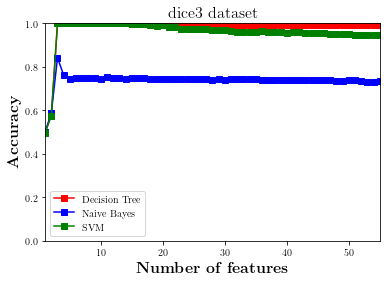

In [49]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Accuracy}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(accuracy_decision_tree) + 1), accuracy_decision_tree, marker='s', color='r', label='Decision Tree')
plt.plot(range(1, len(accuracy_naive_bayes) + 1), accuracy_naive_bayes, marker='s', color='b', label='Naive Bayes')
plt.plot(range(1, len(accuracy_svc) + 1), accuracy_svc, marker='s', color='g', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.show()

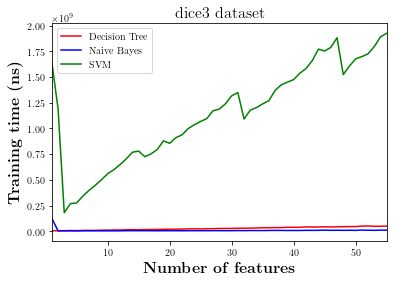

In [50]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'\textbf{Number of features}',fontsize=16)
plt.ylabel(r'\textbf{Training time (ns)}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(decision_tree_time) + 1), decision_tree_time, color='r', label='Decision Tree')
plt.plot(range(1, len(naive_bayes_time) + 1), naive_bayes_time, color='b', label='Naive Bayes')
plt.plot(range(1, len(svc_time) + 1), svc_time, color='g', label='SVM')
plt.xlim([1, len(features.columns)])
plt.legend()
plt.show()

# Regressor evaluation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

r2_svm = []

for n in range(len(features.columns)):
    ref = SVR()
    ref.fit(X_train[prfs.select(n + 1)], y_train)
    r2_svm.append(ref.score(X_test[prfs.select(n + 1)], y_test))

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Number of features',fontsize=16)
plt.ylabel(r'\textbf{$R^2$}',fontsize=16)
plt.title(f'{dataset_name} dataset', fontsize=16)
plt.plot(range(1, len(r2_svm) + 1), r2_svm, marker='s', color='r', label='SVM')
plt.xlim([1, len(features.columns)])
plt.ylim([0, 1])
plt.legend()
plt.show()